In [2]:
import sys
sys.path.append("..")

from tqdm import tqdm
import random
import numpy as np
from environments.grid_world import GridWorld

# 1. Create Grid-world environment

observation_space:  Discrete(16)
action_space:  Discrete(4) [left, down, right ,up]


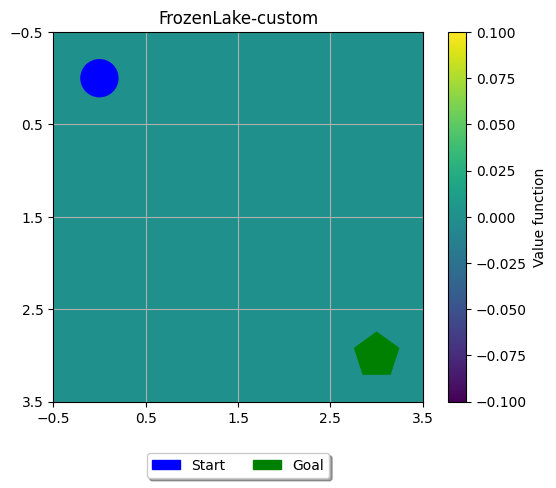

In [43]:
# specify world parameters
num_cols = 4
num_rows = 4
obstructions = None
bad_states = None
restart_states = None  # np.array([[1,1],[1,3],[2,3],[3,0]])
start_state = np.array([[0,0]])
goal_states = np.array([[3,3]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=0,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-10)
gw.add_transition_probability(p_good_transition=1.0, bias=0)
gw.add_discount(discount=1)
env = gw.create_gridworld()

# plot the environment
print('observation_space: ', env.observation_space)
print('action_space: ', env.action_space, '[left, down, right ,up]')
env.render(title="FrozenLake-custom")

In [44]:
# transition function (no stochasticity)
# action: [left, down, right, up]
env.P[1]

{0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 1: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 3: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [45]:
# imidiate reward at each state
env.R[15]

array([10.])

In [46]:
# test environment step
env.reset()
action = env.action_space.sample()
new_state, reward, done, info = env.step(action)
(new_state, reward, done, info)

(0,
 array([0.]),
 False,
 {'probs': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})

# 2. MC Control

In [47]:
def initialize_q_table(env):
    return np.zeros((env.observation_space.n, env.action_space.n))

In [48]:
def generate_episode_from_Q(env, Q, epsilon):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    nA = env.action_space.n
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=_get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def _get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    expected_cummulative_returns = np.zeros(env.observation_space.n)
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for idx, state in enumerate(states):
        _expected_cummulative_return = 0
        for i, reward in enumerate(rewards[idx:]):
            _expected_cummulative_return += reward*discounts[i]
        expected_cummulative_returns[state] += _expected_cummulative_return
        
        Q[state][actions[idx]] += alpha*(expected_cummulative_returns[state] - Q[state][actions[i]])
    return Q

In [49]:
Qtable = initialize_q_table(env)
sample_episode = generate_episode_from_Q(env, Qtable, epsilon=0.1)
print(sample_episode)

[(0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array([0.])), (0, 0, array

In [50]:
Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [51]:
from collections import defaultdict

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # initialize empty Q-table
    # Qtable = initialize_q_table(env)
    Qtable = defaultdict(lambda: np.zeros(env.action_space.n))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Qtable, epsilon)
        # update the action-value function estimate using the episode
        Qtable = update_Q(episode, Qtable, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Qtable.items())
    return policy, Qtable

# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 50000, 0.02)

Episode 50000/50000.

In [52]:
Q

defaultdict(<function __main__.mc_control.<locals>.<lambda>()>,
            {0: array([ 381.67279907,   96.67693535, -107.23679406,  135.70458803]),
             1: array([-299.50277639,  252.4178044 ,  330.11709944,  551.30966887]),
             5: array([ 38.19096808, 101.8429339 , 393.24953653,  -2.69472368]),
             9: array([ 7.80215382, 49.29486956, 67.07418679, 90.97161893]),
             4: array([  21.50981595, -176.71122188,  202.5697299 ,  105.09110568]),
             8: array([121.53516326,   8.31861168,  62.86890732,  21.36520999]),
             10: array([ 367.10902783,  112.86630113, -463.03314911,   73.30738055]),
             14: array([ 62.37608384, -72.99235363,  -6.14783636, 131.1702836 ]),
             13: array([-331.7878303 ,   82.56085453,  875.71934691, -618.17794608]),
             12: array([-16.54531966,  12.19088341, 101.18034172,  30.68598368]),
             6: array([170.40482846, 107.14048066,  67.66105902,  37.73879122]),
             2: array([ 2

In [53]:
policy

{0: 0,
 1: 3,
 5: 2,
 9: 3,
 4: 2,
 8: 0,
 10: 0,
 14: 3,
 13: 2,
 12: 2,
 6: 0,
 2: 0,
 11: 1,
 7: 3,
 3: 2}